## Load dataset

In [52]:
import os
import pandas as pd

# Load the CSV file with the correct encoding and specify headers
file_path = 'texts_2024_1120_aggregate.csv'

# Define the headers
headers = ['fullname', 'Measures', 'Amount', 'Level', 'Function']  # Replace with your actual headers

df = pd.read_csv(file_path, encoding='latin1', names=headers, header=0)
df['filename'] = df['fullname'].str.split('/').str[-1]

# Extract type, id, and model
df[['type', 'id', 'model']] = df['filename'].str.extract(r'(\w+)_(\d+)@(\w+)')
#measures_to_compare = unique[1::5][:50]
filtered_measures = [measure for measure in df['Measures'] if ('(par' or '-par')not in measure.lower()]
print(filtered_measures[:15])
# Prepare DataFrames for comparison
df = df[df['Measures'].isin(filtered_measures)]
grouped2 = df.groupby(['type', 'model', 'Measures'])

filtered_measures2 = [measure for measure in df['Measures'] if '(Doc)' in measure]
#df = df[df['type'] == 'acad']

dfDoc = df[df['Measures'].isin(filtered_measures2)]
df = df.drop(columns=['Level','Function', 'fullname', 'filename'])
pivot_df = df.pivot(index=['id', 'model', 'type'], columns='Measures', values='Amount').reset_index()
print(pivot_df[:6])



['Letter count (Sent Avg)', 'Letter count (Sent SD)', 'Letter count (Sent Max)', 'Letter count (Sent Min)', 'Word count (Doc)', 'Word count (Sent Avg)', 'Word count (Sent SD)', 'Word count (Sent Max)', 'Word count (Sent Min)', 'Type count (Doc)', 'Type count (Sent Avg)', 'Type count (Sent SD)', 'Type count (Sent Max)', 'Type count (Sent Min)', 'Sentence count (Doc)']
Measures    id    model  type  Adjective avg position (Doc)  \
0         0007     Meta  acad                      0.496633   
1         0007     Meta   fic                      0.526100   
2         0007  chunk_1  acad                      0.350858   
3         0007  chunk_1   fic                      0.536830   
4         0007  chunk_2  acad                      0.373590   
5         0007  chunk_2   fic                      0.533355   

Measures  Adjective avg position (Sent Avg)  \
0                                  0.375528   
1                                  0.311252   
2                                  0.305196   


## Load predictable data

In [138]:

def parse_linguistic_data(data):
    lines = data.split('\n')
    headers = lines[0].split('\t')
    parsed_data = {header: [] for header in headers}
    
    skip_next = False

    for i, line in enumerate(lines[1:], start=1):
        if skip_next:
            skip_next = False
            continue

        values = line.split('\t')
        if any('par' in value.lower() for value in values):
            skip_next = True
            continue

        for header, value in zip(headers, values):
            parsed_data[header].append(value)
    
    return parsed_data


filehum = 'analysis-results(4).txt'
with open(filehum, 'r') as gpt_file:
    gpt_data = gpt_file.read()
gpt_parsed = parse_linguistic_data(gpt_data)

newX = pd.DataFrame([gpt_parsed['Text 1'][1:]], columns=gpt_parsed['Measures'][2:])
print(newX)

  Letter count (Sent Avg) Letter count (Sent SD) Letter count (Sent Max)  \
0                 2387.00                  64.51                   31.66   

  Letter count (Sent Min) Word count (Doc) Word count (Sent Avg)  \
0                  143.00            18.00                548.00   

  Word count (Sent SD) Word count (Sent Max) Word count (Sent Min)  \
0                14.81                  7.33                 31.00   

  Type count (Doc)  ... Levenshtein PoS dist. (Sent-Sent Min)  \
0             5.00  ...                                  0.92   

  Cosine dist. (Sent-Doc Avg) Cosine dist. (Sent-Doc SD)  \
0                        0.46                       0.70   

  Cosine dist. (Sent-Doc Max) Cosine dist. (Sent-Doc Min)  \
0                        0.13                        0.86   

  Cosine dist. (Sent-Sent Avg) Cosine dist. (Sent-Sent SD)  \
0                         0.35                        0.53   

  Cosine dist. (Sent-Sent Max) Cosine dist. (Sent-Sent Min)        
0

In [139]:
expected_features = rf_model.feature_names_in_  # Features used during fit

# Add missing columns with default values
for feature in expected_features:
    if feature not in newX.columns:
        newX[feature] = 0  # Default value (adjust as needed)
        print(feature)

# Ensure columns are in the correct order
newX = newX[expected_features]

y_pred3 = rf_model.predict(newX)
print(y_pred3)

Auxiliary-lexical verb ratio (Doc)
Hapax legomena count (Doc)
Letter count (Doc)
Pronoun avg position (Doc)
Pronoun burstiness (Doc)
Pronoun concentration (Doc)
Pronoun count (Doc)
Pronoun incidence (Doc)
Pronoun length (Doc)
Pronoun position SD (Doc)
Pronoun type count (Doc)
Pronoun type-token ratio (Doc)
Pronoun-grammatical item ratio (Doc)
Type-token ratio (Doc)
[ True]


## Logistic Regression


In [23]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.datasets import make_classification
from sklearn.impute import SimpleImputer

# Example: Using a synthetic dataset
from sklearn.datasets import make_classification
X = pivot_df.drop(columns=['model', 'id', 'type'])
X = X.loc[:, X.isnull().sum() == 0]
print(X.isnull().sum().sum())

y = pivot_df['model'].isin(['gpt', 'Meta'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{cm}')

0
Accuracy: 0.8375
Confusion Matrix:
[[23  7]
 [ 6 44]]


c:\Users\20191882\Anaconda\envs\Work\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [28]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# Assuming pivot_df is already defined
# Prepare the data
X = pivot_df.drop(columns=['model', 'id', 'type'])
X = X.loc[:, X.isnull().sum() == 0]  # Drop columns with any missing values
print(f'Total missing values in X: {X.isnull().sum().sum()}')

y = pivot_df['model'].isin(['gpt', 'Meta']).astype(int)
print(y.value_counts())

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Lasso-penalized logistic regression with 10-fold CV
model_cv = LogisticRegressionCV(
    Cs=10,               # Number of Cs to try
    cv=10,               # 10-fold cross-validation
    penalty='l1',        # Lasso penalty
    solver='saga',       # Solver that supports L1 penalty
    scoring='accuracy',  # Evaluation metric
    n_jobs=-1,           # Use all cores
    random_state=42,
    max_iter=10000
)

# Fit the model with cross-validation
model_cv.fit(X_train, y_train)

# Implement the one-standard-error rule
# Get mean and standard deviation of scores across folds for each C
mean_scores = np.mean(model_cv.scores_[1], axis=0)
std_scores = np.std(model_cv.scores_[1], axis=0)

# Find the best mean score and its index
best_score_index = np.argmax(mean_scores)
best_score = mean_scores[best_score_index]
best_score_std = std_scores[best_score_index]

# Compute the threshold: best score minus one standard error
threshold = best_score - (best_score_std / np.sqrt(10))  # n_folds = 10

# Sort Cs from smallest to largest (more regularization to less)
Cs = model_cv.Cs_
sorted_indices = np.argsort(Cs)
Cs_sorted = Cs[sorted_indices]
mean_scores_sorted = mean_scores[sorted_indices]

# Find the simplest model within one standard error of the best score
indices_within_threshold = np.where(mean_scores_sorted >= threshold)[0]

if len(indices_within_threshold) > 0:
    # Select the simplest model (smallest C)
    one_se_index = indices_within_threshold[0]
else:
    # If none are within the threshold, select the best model
    one_se_index = best_score_index

C_one_se = Cs_sorted[one_se_index]
print(f'Selected C using one-standard-error rule: {C_one_se}')

# Refit the model on the training data using the selected C
final_model = LogisticRegression(
    C=C_one_se,
    penalty='l1',
    solver='saga',
    random_state=42,
    max_iter=10000
)

final_model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = final_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f'Accuracy on test set: {accuracy}')
print(f'Confusion Matrix:\n{cm}')

Total missing values in X: 0
model
1    200
0    200
Name: count, dtype: int64
Selected C using one-standard-error rule: 0.005994842503189409


KeyboardInterrupt: 

In [8]:
print(df.isnull().sum())

Measures    0
Amount      0
type        0
id          0
model       0
dtype: int64


## RandomForest

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Drop columns that are not features
X = pivot_df.drop(columns=['model', 'id', 'type'])
y = pivot_df['model'].isin(['gpt', 'Meta'])

# Impute missing values
imputer = SimpleImputer(strategy='mean')  # You can also use 'median', 'most_frequent', or 'constant'
X_imputed = imputer.fit_transform(X)

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Apply PCA
pca = PCA(n_components=0.5)  # Retain 50% of the variance
X_pca = pca.fit_transform(X_scaled)

# Initialize stratified k-fold cross-validation
skf = StratifiedKFold(n_splits=5)

# Iterate through the folds
for train_index, test_index in skf.split(X_pca, y):
    X_train, X_test = X_pca[train_index], X_pca[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train your model
    model = RandomForestClassifier(n_estimators=1, random_state=42)
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

Accuracy: 0.675
              precision    recall  f1-score   support

       False       0.67      0.70      0.68        40
        True       0.68      0.65      0.67        40

    accuracy                           0.68        80
   macro avg       0.68      0.68      0.67        80
weighted avg       0.68      0.68      0.67        80

Accuracy: 0.6125
              precision    recall  f1-score   support

       False       0.62      0.60      0.61        40
        True       0.61      0.62      0.62        40

    accuracy                           0.61        80
   macro avg       0.61      0.61      0.61        80
weighted avg       0.61      0.61      0.61        80

Accuracy: 0.7625
              precision    recall  f1-score   support

       False       0.82      0.68      0.74        40
        True       0.72      0.85      0.78        40

    accuracy                           0.76        80
   macro avg       0.77      0.76      0.76        80
weighted avg       0.77 

#### skf split

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import StratifiedKFold

X = pivot_df.drop(columns=['model', 'id', 'type'])
y = pivot_df['model'].isin(['gpt', 'Meta'])
# Initialize stratified k-fold cross-validation
skf = StratifiedKFold(n_splits=5)

# Iterate through the folds
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train your model
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

Accuracy: 0.95
              precision    recall  f1-score   support

       False       0.93      0.97      0.95        40
        True       0.97      0.93      0.95        40

    accuracy                           0.95        80
   macro avg       0.95      0.95      0.95        80
weighted avg       0.95      0.95      0.95        80

Accuracy: 0.9375
              precision    recall  f1-score   support

       False       0.91      0.97      0.94        40
        True       0.97      0.90      0.94        40

    accuracy                           0.94        80
   macro avg       0.94      0.94      0.94        80
weighted avg       0.94      0.94      0.94        80

Accuracy: 0.9125
              precision    recall  f1-score   support

       False       0.92      0.90      0.91        40
        True       0.90      0.93      0.91        40

    accuracy                           0.91        80
   macro avg       0.91      0.91      0.91        80
weighted avg       0.91  

In [150]:
from sklearn.metrics import confusion_matrix

# Sample true labels and predicted labels
true_labels = y_test
predicted_labels = y_pred

# Generate the confusion matrix
#cm = confusion_matrix(true_labels, predicted_labels, labels=['Meta', 'chunk_1', 'chunk_2', 'gpt'])
cm = confusion_matrix(true_labels, predicted_labels, labels=[True, False])
# Create a DataFrame from the confusion matrix
#cm_df = pd.DataFrame(cm, index=['Meta', 'chunk_1', 'chunk_2', 'gpt'], columns=['Meta', 'chunk_1', 'chunk_2', 'gpt'])
cm_df = pd.DataFrame(cm, index=[True, False], columns=[True, False])
# Add a column for the true labels
cm_df['True Label'] = cm_df.index

# Melt the DataFrame to get a long format
cm_melted = cm_df.melt(id_vars='True Label', var_name='Predicted Label', value_name='Count')

# Filter out the correct predictions
incorrect_predictions = cm_melted[cm_melted['True Label'] != cm_melted['Predicted Label']]

print("Confusion Matrix:")
print(cm_df)
print("\nIncorrect Predictions:")
print(incorrect_predictions)

Confusion Matrix:
       True  False  True Label
True     34      6        True
False    12     28       False

Incorrect Predictions:
   True Label Predicted Label  Count
1       False            True     12
2        True           False      6


## Feature Importance

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Get feature importances
importances = rf_model.feature_importances_

# Combine with feature names
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Sort by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print(feature_importances[:20])

def plot_boxplots(pivot_df, col):
    # Create a new column to categorize the models
    pivot_df['Model Category'] = pivot_df['model'].apply(lambda x: 'LLM written' if x in ['gpt', 'Meta'] else 'Human-Written')

    # Create the boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Model Category', y=col, data=pivot_df)
    
    # Add title and labels
    plt.title('Boxplot of ' + col + ' by Model Category')
    plt.xlabel('Model Category')
    plt.ylabel(col)
    
    # Show the plot
    plt.show()

# Example usage
for i in range(0, 1):
    val = feature_importances[i:i+1]['Feature'].values[0]
    plot_boxplots(pivot_df, val)
    
for i in range(0, 5):
    val = feature_importances[len(feature_importances)-i - 1:len(feature_importances)-i]['Feature'].values[0]
    plot_boxplots(pivot_df, val)


NameError: name 'rf_model' is not defined

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
piv = pivot_df[pivot_df['model']!='chunk_1']
# Drop columns that are not features
X = piv.drop(columns=['model', 'id', 'type'])
y = piv['model']
# Impute missing values
imputer = SimpleImputer(strategy='mean')  # You can also use 'median', 'most_frequent', or 'constant'
X_imputed = imputer.fit_transform(X)
X_pca = X_imputed
# Standardize the data3
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X_imputed)

# # Apply PCA
# pca = PCA(n_components=0.95)  # Retain 50% of the variance
# X_pca = pca.fit_transform(X_scaled)

# Initialize stratified k-fold cross-validation
skf = StratifiedKFold(n_splits=5)

# Iterate through the folds
for train_index, test_index in skf.split(X_pca, y):
    X_train, X_test = X_pca[train_index], X_pca[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train your model
    model = RandomForestClassifier(n_estimators=50, random_state=42)
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    

Accuracy: 0.9333333333333333
              precision    recall  f1-score   support

        Meta       0.94      0.85      0.89        20
     chunk_2       0.90      0.95      0.93        20
         gpt       0.95      1.00      0.98        20

    accuracy                           0.93        60
   macro avg       0.93      0.93      0.93        60
weighted avg       0.93      0.93      0.93        60

Accuracy: 0.8666666666666667
              precision    recall  f1-score   support

        Meta       0.83      0.75      0.79        20
     chunk_2       0.81      0.85      0.83        20
         gpt       0.95      1.00      0.98        20

    accuracy                           0.87        60
   macro avg       0.87      0.87      0.86        60
weighted avg       0.87      0.87      0.86        60

Accuracy: 0.9166666666666666
              precision    recall  f1-score   support

        Meta       0.90      0.90      0.90        20
     chunk_2       0.90      0.90      0.9

[0.         0.00049792 0.         ... 0.         0.         0.        ]
                                         Feature  Importance
808   Levenshtein character dist. (Sent-Doc Min)    0.022877
966                        Noun type count (Doc)    0.018897
934        Moving average type-token ratio (Doc)    0.017635
1480                            Type count (Doc)    0.016049
507                    Frequent word count (Doc)    0.015837
809    Levenshtein character dist. (Sent-Doc SD)    0.012659
813    Levenshtein character dist. (Sent-Par SD)    0.012584
1031                Numeral-noun ratio (Sent SD)    0.012368
914                Lexical verb type count (Doc)    0.012241
1598                            Word count (Doc)    0.010823
797          Levenshtein PoS dist. (Sent-Doc SD)    0.010749
1618           Word overlap count (Sent-Par Max)    0.010687
574                   Hapax legomena count (Doc)    0.010411
836        Levenshtein word dist. (Sent-Par Min)    0.010287
820       Lev

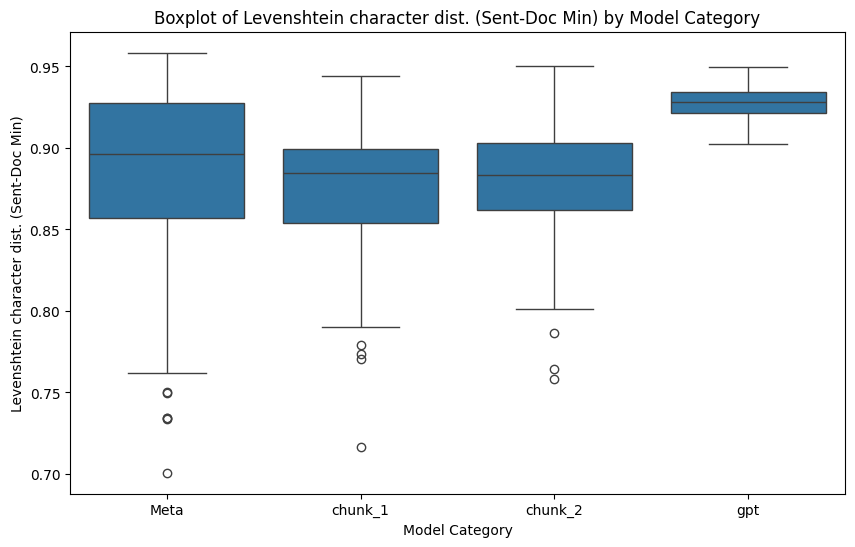

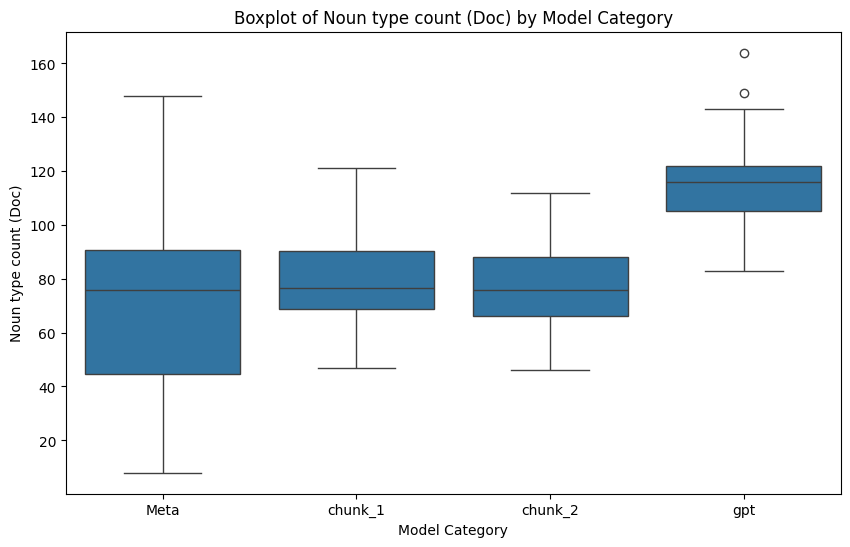

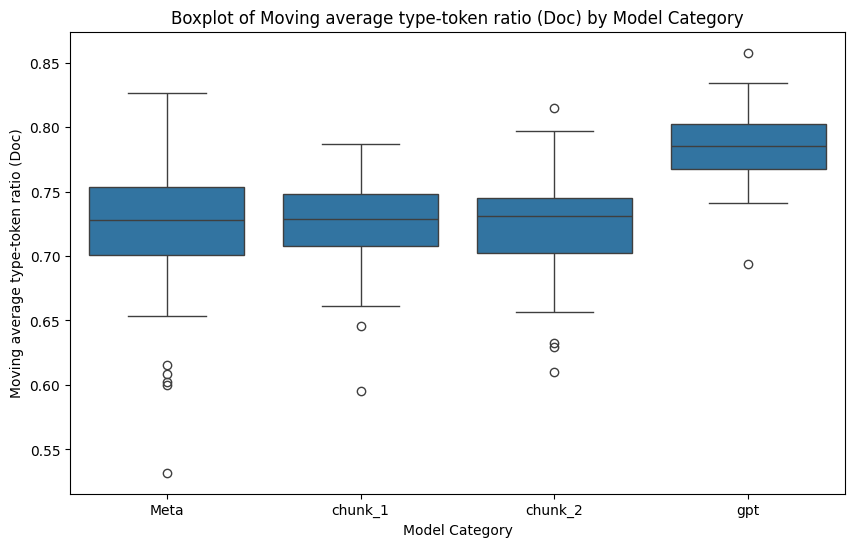

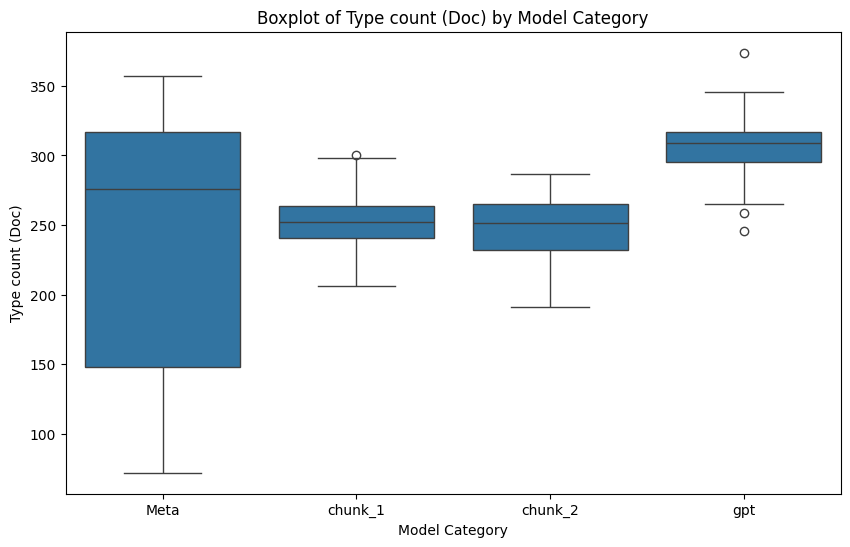

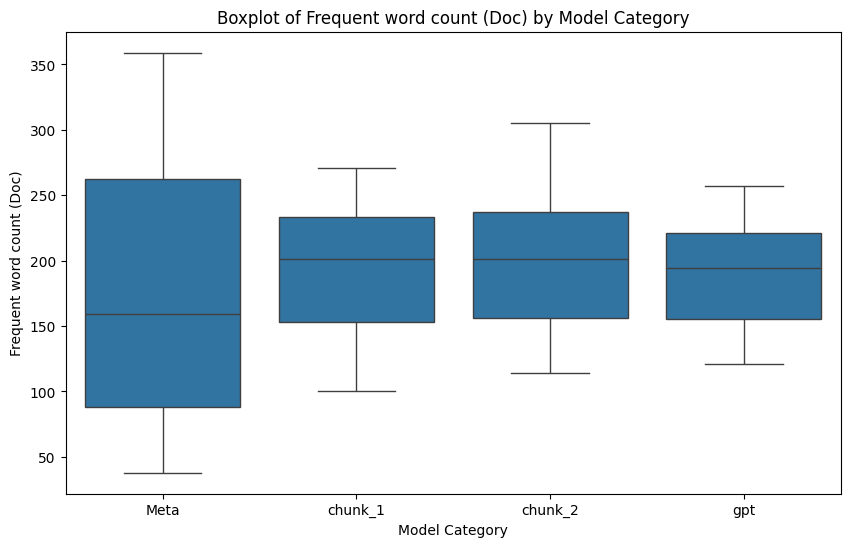

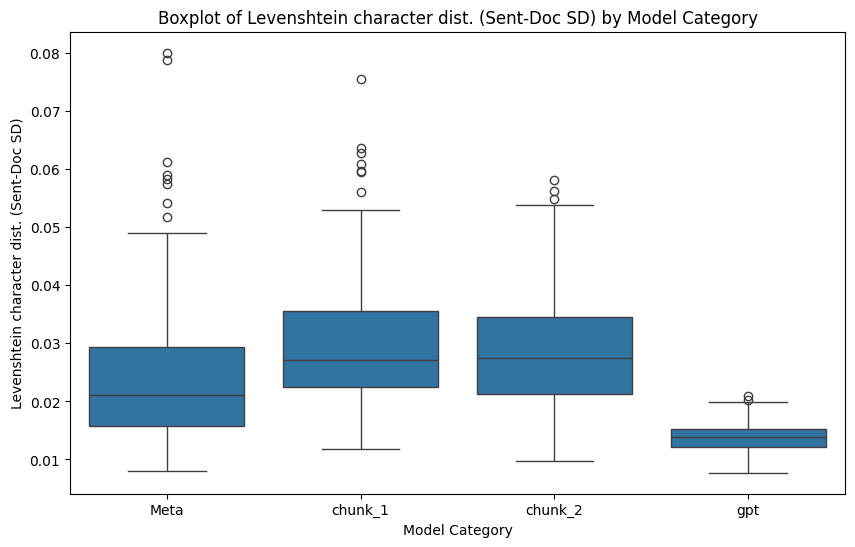

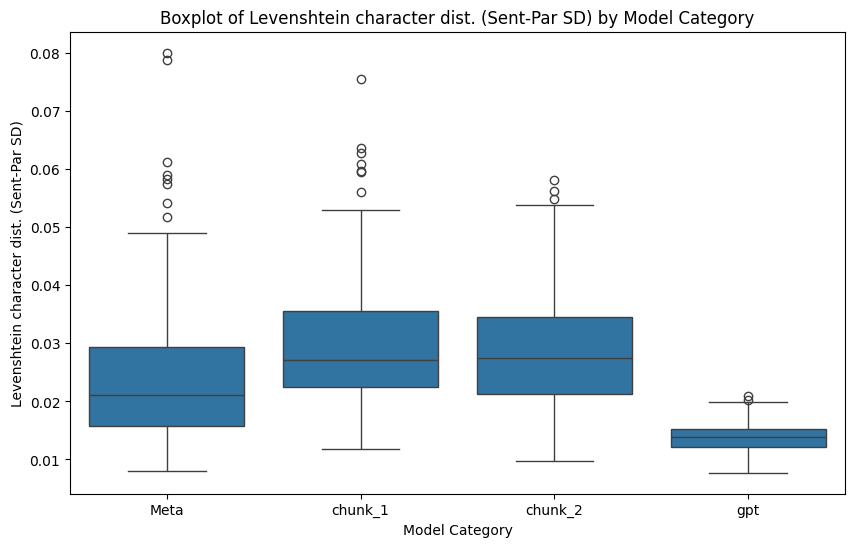

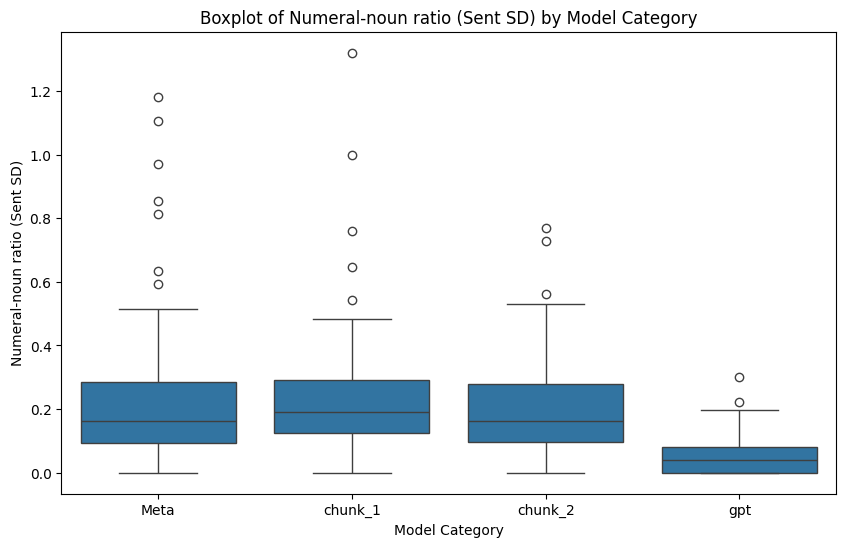

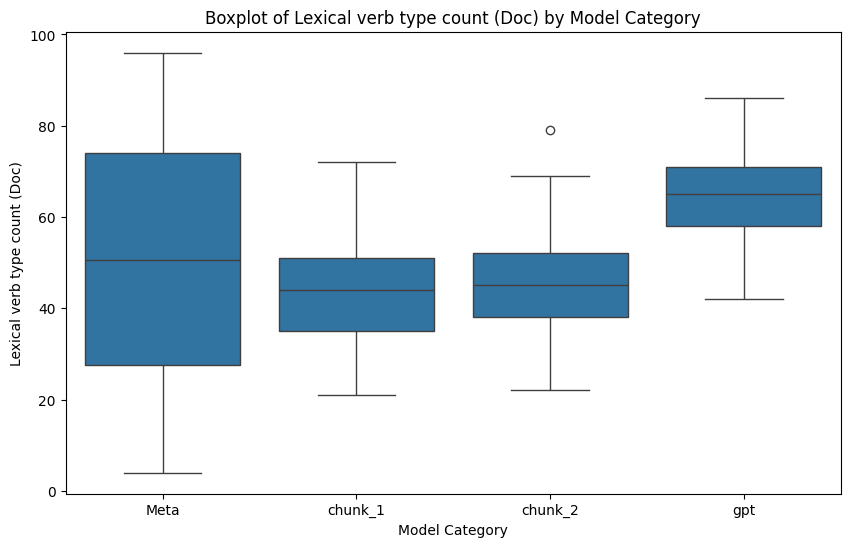

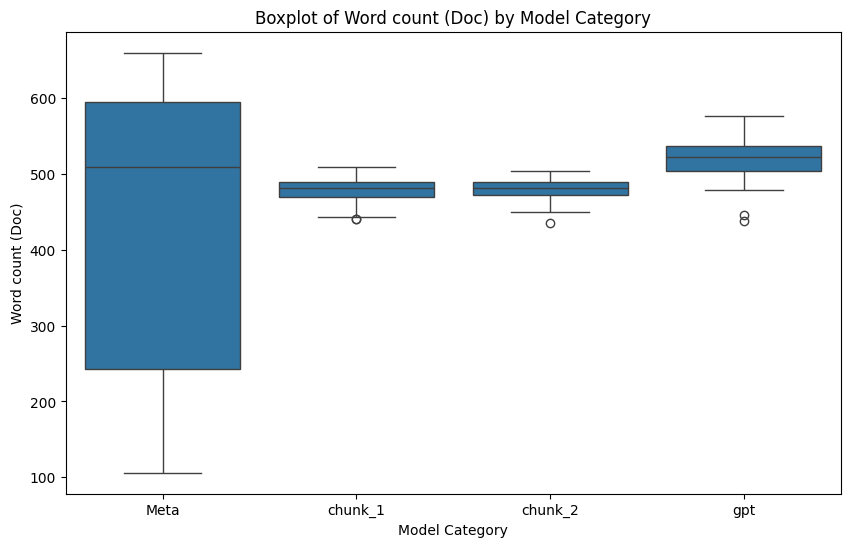

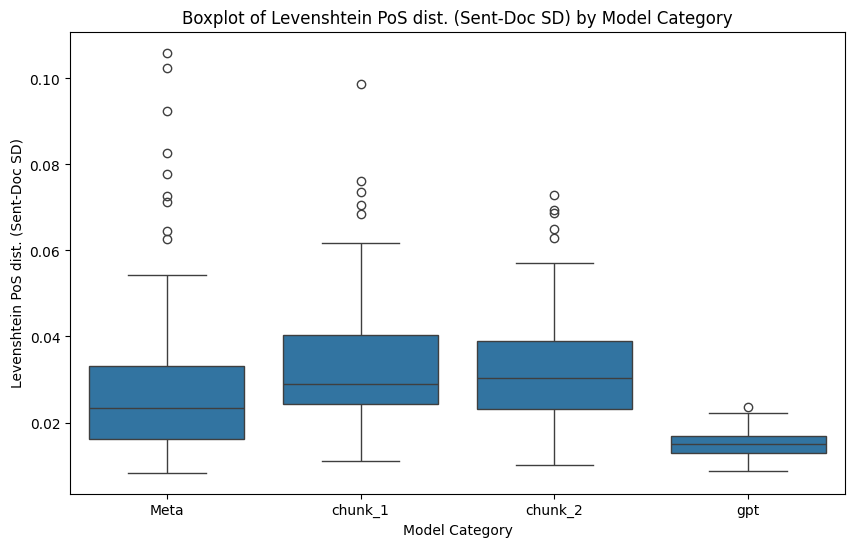

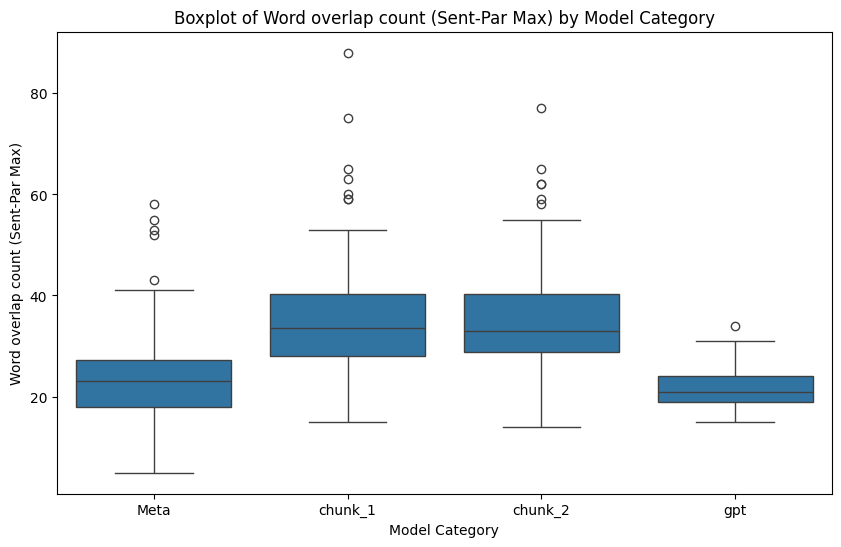

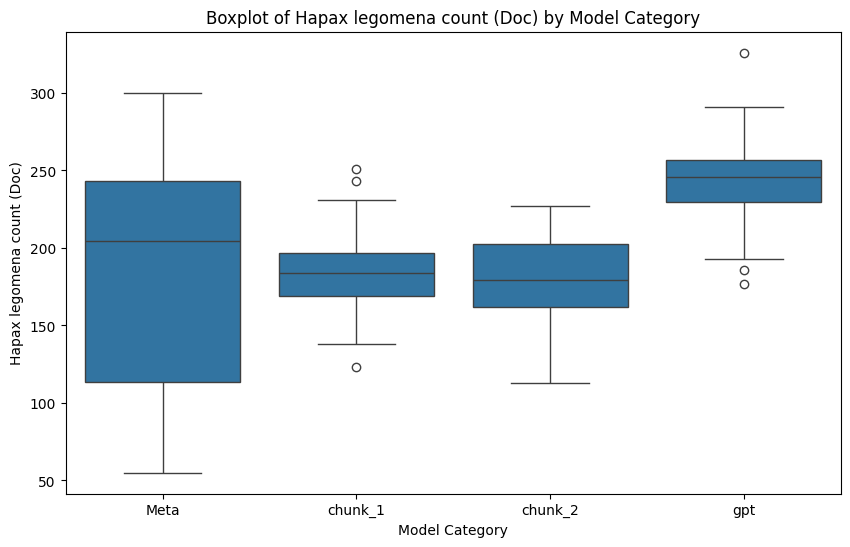

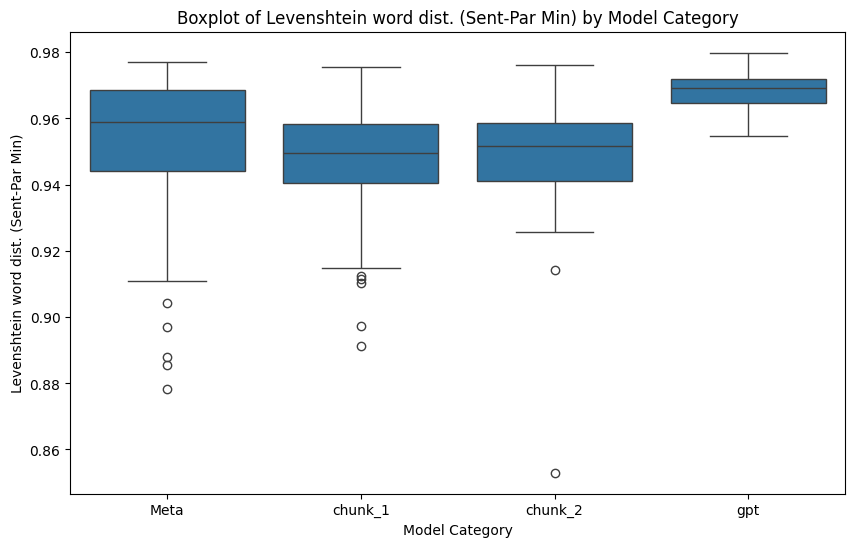

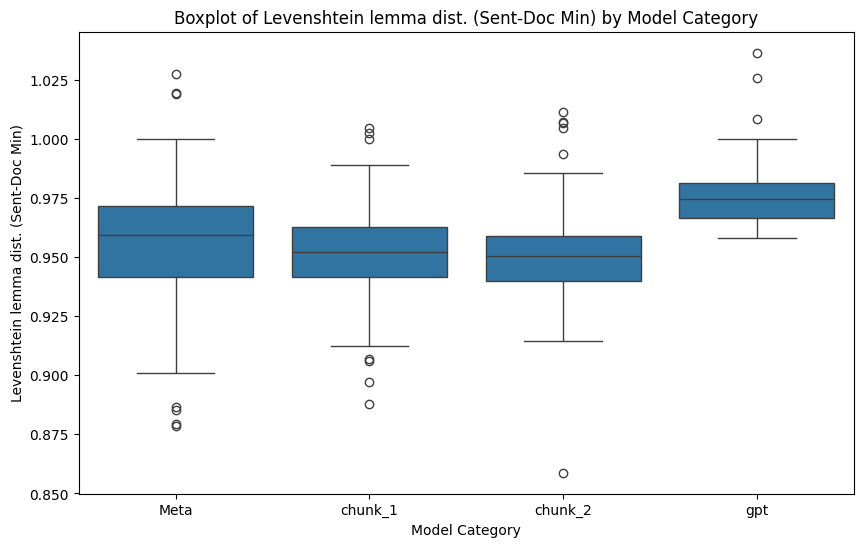

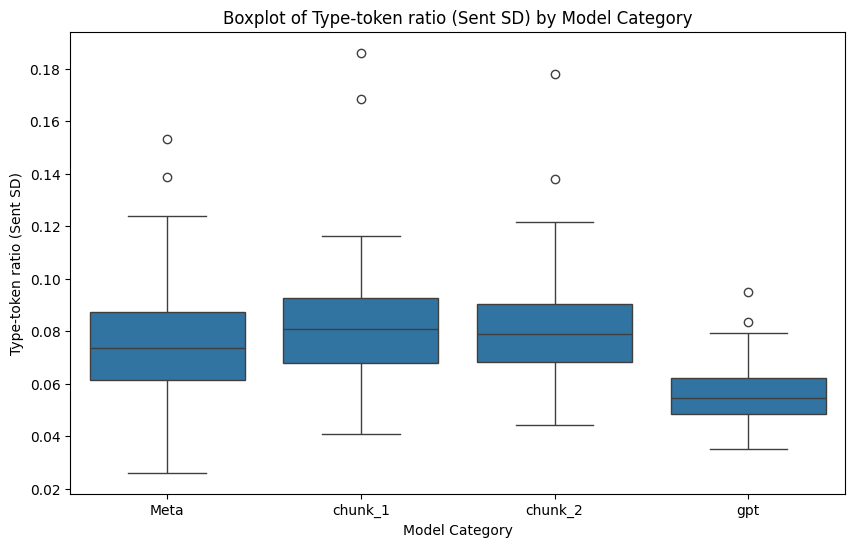

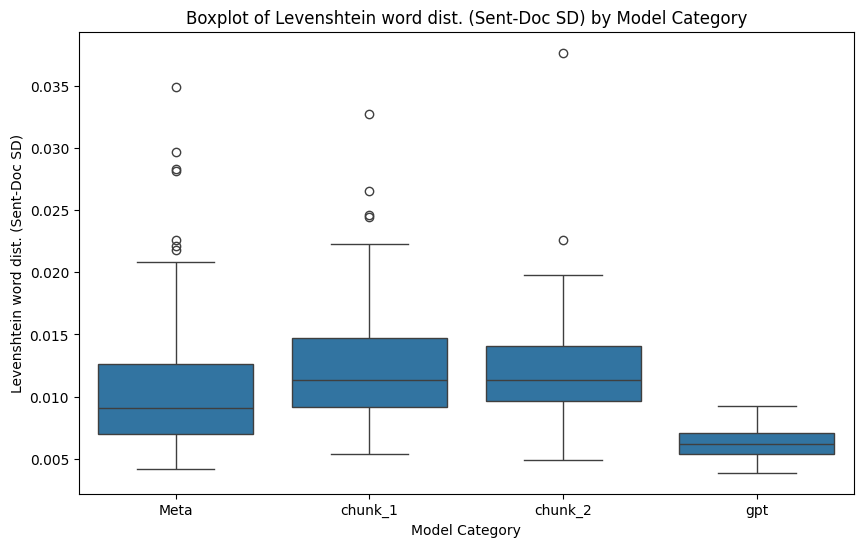

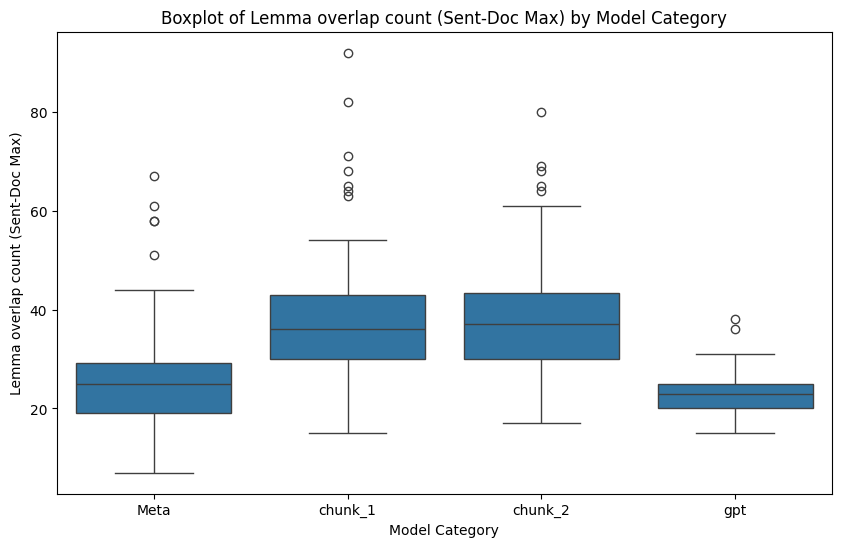

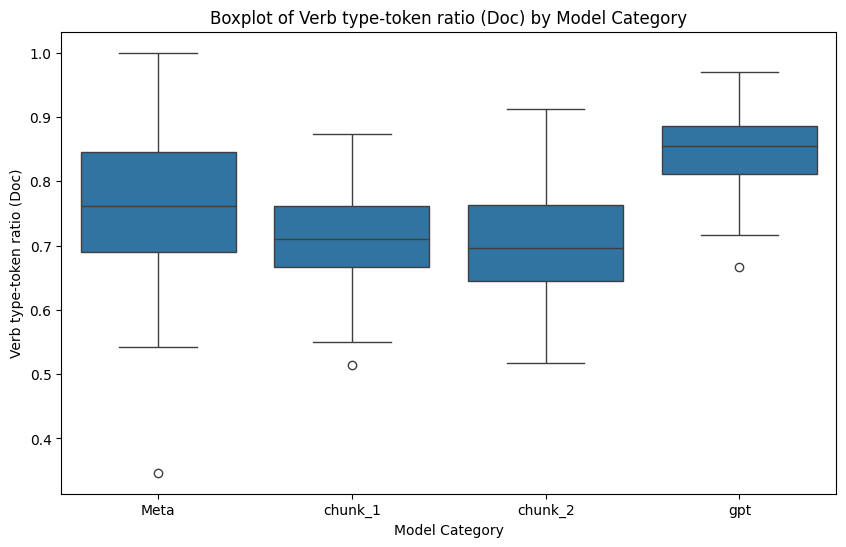

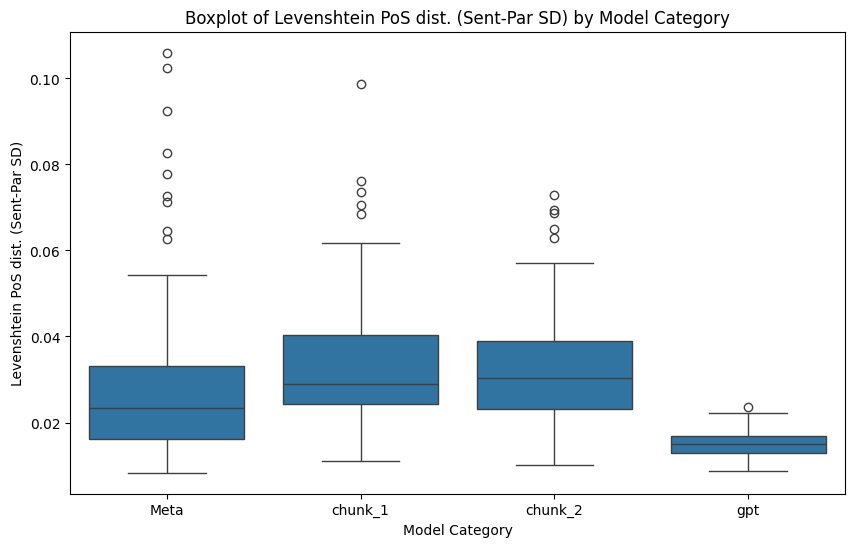

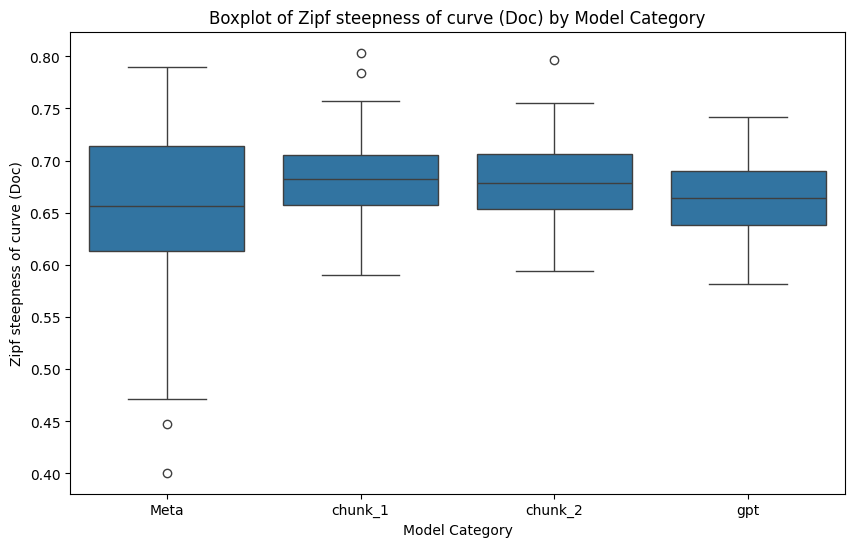

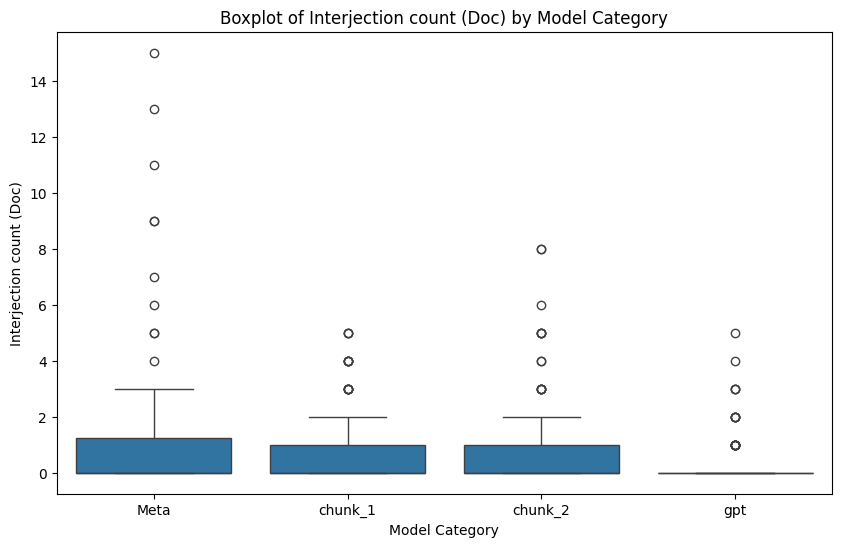

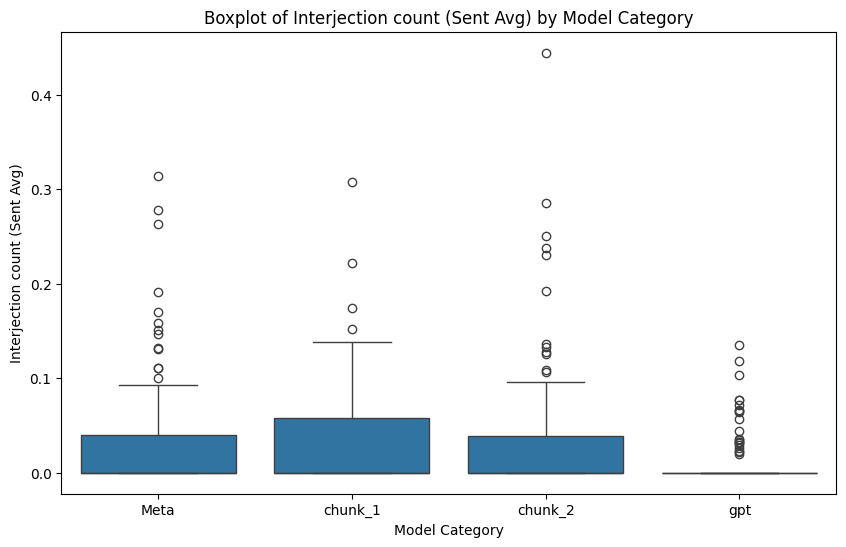

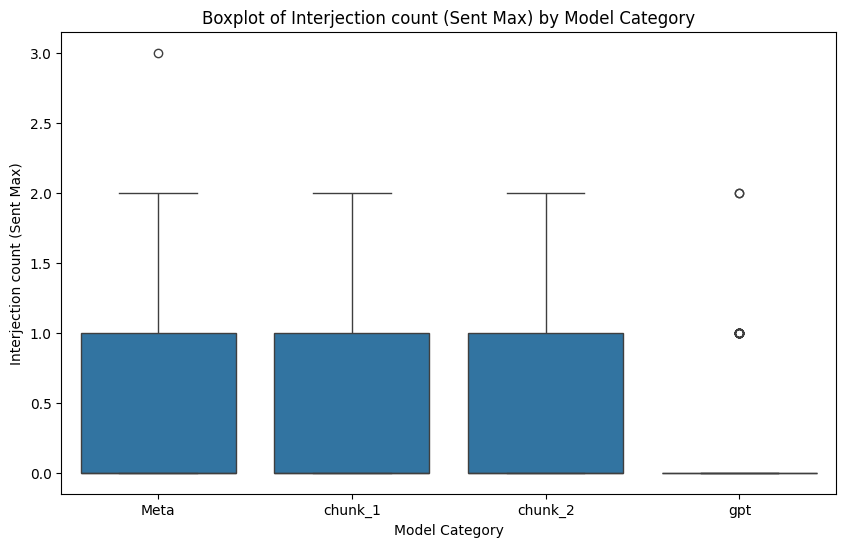

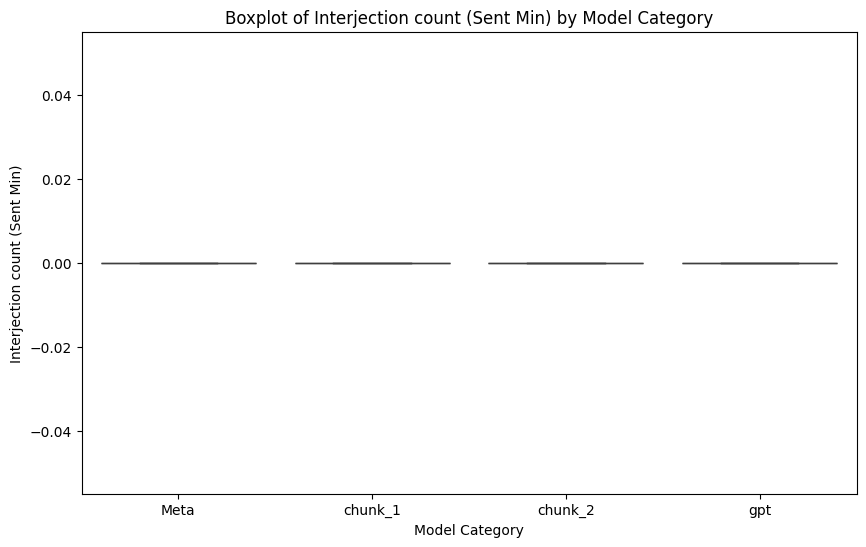

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Get feature importances
importances = model.feature_importances_
print(importances)

# Combine with feature names
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Sort by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print(feature_importances[:20])

def plot_boxplots(pivot_df, col):
    # Create a new column to categorize the models
    pivot_df['Model Category'] = pivot_df['model']

    # Create the boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Model Category', y=col, data=pivot_df)
    
    # Add title and labels
    plt.title('Boxplot of ' + col + ' by Model Category')
    plt.xlabel('Model Category')
    plt.ylabel(col)
    
    # Show the plot
    plt.show()

# Example usage
for i in range(0, 20):
    val = feature_importances[i:i+1]['Feature'].values[0]
    plot_boxplots(pivot_df, val)
    
for i in range(0, 5):
    val = feature_importances[len(feature_importances)-i - 1:len(feature_importances)-i]['Feature'].values[0]
    plot_boxplots(pivot_df, val)


In [86]:
print(piv[(piv['Word count (Doc)'] > 600) | (piv['Word count (Doc)'] < 200)][['Word count (Doc)', 'model', 'type']])
print(piv[(piv['model'] == 'gpt')]['Word count (Doc)'].mean())
print(piv[(piv['model'] == 'Meta')]['Word count (Doc)'].mean())
print(piv[(piv['model'] == 'chunk_2')]['Word count (Doc)'].mean())

Measures  Word count (Doc) model  type
0                    132.0  Meta  acad
9                    653.0  Meta   fic
16                   123.0  Meta  acad
17                   602.0  Meta   fic
24                   135.0  Meta  acad
25                   625.0  Meta   fic
33                   601.0  Meta   fic
41                   135.0  Meta   fic
48                   609.0  Meta  acad
57                   610.0  Meta   fic
73                   133.0  Meta   fic
81                   625.0  Meta   fic
96                   150.0  Meta  acad
104                  107.0  Meta  acad
105                  660.0  Meta   fic
113                  622.0  Meta   fic
120                  151.0  Meta  acad
121                  651.0  Meta   fic
129                  156.0  Meta   fic
153                  601.0  Meta   fic
185                  638.0  Meta   fic
193                  644.0  Meta   fic
200                  188.0  Meta  acad
201                  614.0  Meta   fic
208                  614.